## Dijkstra revision

code exploring alternatives with Dijkstra algorithm

In [ ]:
#### import pandas as pd
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import osmnx as ox
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
import folium, itertools, os, time, warnings
from IPython.display import display, clear_output

warnings.filterwarnings("ignore")

### Directories

In [ ]:
os.getcwd()

In [ ]:
## Use to set work directory properly
if os.getcwd() == '/home/jovyan/work/RP-Kang2020/procedure/code':
    os.chdir('../../')
if os.getcwd() == '/home/jovyan/work/RP-Kang2020/':
    None 

os.getcwd()

### Load Data and Set Parameters

In [ ]:
# street networks
if not os.path.exists("data/raw/public/Chicago_Network.graphml"):
    G = ox.graph_from_place('Chicago', network_type='drive') # pulling the drive network the first time will take a while
    ox.save_graphml(G, 'raw/public/Chicago_Network.graphml')
else:
    G = ox.load_graphml('raw/public/Chicago_Network.graphml', node_type=str)
ox.plot_graph(G)

In [ ]:
hospitals = gpd.read_file('./data/raw/public/HospitalData/Chicago_Hospital_Info.shp')

In [ ]:
pop_data = gpd.read_file('./data/raw/public/PopData/Chicago_Tract.shp')

In [ ]:
distances = [10,20,30]
weights = [1,0, 0.68, 0.22]
distance_unit = 'time'
nearest_osm = hospitals['nearest_osm'][0]
weights = [1, 0.68, 0.22]

### Process Hospitals + Street Networks

In [ ]:
def network_setting(network):
    _nodes_removed = len([n for (n, deg) in network.out_degree() if deg ==0])
    network.remove_nodes_from([n for (n, deg) in network.out_degree() if deg ==0])
    for component in list(nx.strongly_connected_components(network)):
        if len(component)<10:
            for node in component:
                _nodes_removed+=1
                network.remove_node(node)
    for u, v, k, data in tqdm(G.edges(data=True, keys=True),position=0):
        if 'maxspeed' in data.keys():
            speed_type = type(data['maxspeed'])
            if (speed_type==str):
                # add in try/except blocks to catch maxspeed formats that don't fit Kang et al's cases
                try:
                    if len(data['maxspeed'].split(','))==2:
                        data['maxspeed_fix']=float(data['maxspeed'].split(',')[0])                  
                    elif data['maxspeed']=='signals':
                        data['maxspeed_fix']=35.0 # drive speed setting as 35 miles
                    else:
                        data['maxspeed_fix']=float(data['maxspeed'].split()[0])
                        # print("Warning: the value of", data['maxspeed'], "is being converted to 35.0")   
                except:
                    data['maxspeed_fix']= 35.0 #miles
            else:
                try:
                    data['maxspeed_fix']=float(data['maxspeed'][0].split()[0])
                except:
                    data['maxspeed_fix']= 35.0 #miles
        else:
            data['maxspeed_fix']= 35.0 #miles
        # conversion confusion
        data['maxspeed_meters'] = data['maxspeed_fix']*26.8223 # convert (mile per hour) to (meters per minute)
        # meters / meters per minute === 
        data['time'] = float(data['length'])/ data['maxspeed_meters']
    print("Removed {} nodes ({:2.4f}%) from the OSMNX network".format(_nodes_removed, _nodes_removed/float(network.number_of_nodes())))
    print("Number of nodes: {}".format(network.number_of_nodes()))
    print("Number of edges: {}".format(network.number_of_edges()))
    return(network)

def hospital_setting(hospitals, G):
    hospitals['nearest_osm']=None
    for i in tqdm(hospitals.index, desc="Find the nearest osm from hospitals", position=0):
        hospitals['nearest_osm'][i] = ox.get_nearest_node(G, [hospitals['Y'][i], hospitals['X'][i]], method='euclidean') # find the nearest node from hospital location
    print ('hospital setting is done')
    return(hospitals)

def pop_centroid (pop_data, pop_type):
    pop_data = pop_data.to_crs({'init': 'epsg:4326'})
    if pop_type =="pop":
        pop_data=pop_data[pop_data['OverFifty']>=0] 
    if pop_type =="covid":
        pop_data=pop_data[pop_data['cases']>=0]
    pop_cent = pop_data.centroid # it make the polygon to the point without any other information
    pop_centroid = gpd.GeoDataFrame()
    i = 0
    for point in tqdm(pop_cent, desc='Pop Centroid File Setting', position=0):
        if pop_type== "pop":
            pop = pop_data.iloc[i]['OverFifty']
            code = pop_data.iloc[i]['GEOID']
        if pop_type =="covid":
            pop = pop_data.iloc[i]['cases']
            code = pop_data.iloc[i].ZCTA5CE10
        pop_centroid = pop_centroid.append({'code':code,'pop': pop,'geometry': point}, ignore_index=True)
        i = i+1
    return(pop_centroid)

In [ ]:
# clean street network
G = network_setting(G)

# find nearest node for each hospital
hospitals = hospital_setting(hospitals, G)

### Current Functions (for reference)

In [13]:
def dijkstra_cca(G, nearest_osm, distance, distance_unit = "time"):
    # creates subgraph (a list of nodes instead of writing a whole new network graph)
    road_network = G.subgraph(nx.single_source_dijkstra_path_length(G, nearest_osm, distance, distance_unit))  
    # creates an x and y point for each node
    nodes = [Point((data['x'], data['y'])) for node, data in road_network.nodes(data=True)]
    # constructs a multipart convex hull out of the subgraph of nodes
    polygon = gpd.GeoSeries(nodes).unary_union.convex_hull ## to create convex hull
    # turns the polygon into a geodatframme
    polygon = gpd.GeoDataFrame(gpd.GeoSeries(polygon)) ## change polygon to geopandas
    # renames geometry column
    polygon = polygon.rename(columns={0:'geometry'}).set_geometry('geometry')
    return polygon.copy(deep=True)

In [14]:
def hospital_measure_acc (_thread_id, hospital, pop_data, distances, weights):
    ##distance weight = 1, 0.68, 0.22
    polygons = []
    for distance in distances:
        # append djikstra catchment calculation (uncomment to use)
        polygons.append(dijkstra_cca(G, nearest_osm, distance))
        ## comment out original approach
        # polygons.append(calculate_catchment_area(G, hospital['nearest_osm'],distance))
    print(polygons)
    for i in reversed(range(1, len(distances))):
        polygons[i] = gpd.overlay(polygons[i], polygons[i-1], how="difference")
    print(polygons)
        
    num_pops = []
    for j in pop_data.index:
        point = pop_data['geometry'][j]
        for k in range(len(polygons)):
            if len(polygons[k]) > 0: # to exclude the weirdo (convex hull is not polygon)
                if (point.within(polygons[k].iloc[0]["geometry"])):
                    num_pops.append(pop_data['Pop'][j]*weights[k])  
    total_pop = sum(num_pops)
    for i in range(len(distances)):
        polygons[i]['time']=distances[i]
        polygons[i]['total_pop']=total_pop
        polygons[i]['hospital_icu_beds'] = float(hospital['Adult ICU'])/polygons[i]['total_pop'] # proportion of # of beds over pops in 10 mins
        polygons[i]['hospital_vents'] = float(hospital['Total Vent'])/polygons[i]['total_pop'] # proportion of # of beds over pops in 10 mins
        polygons[i].crs = { 'init' : 'epsg:4326'}
        polygons[i] = polygons[i].to_crs({'init':'epsg:32616'})
    print('\rCatchment for hospital {:4.0f} complete'.format(_thread_id), end="")
    return(_thread_id, [ polygon.copy(deep=True) for polygon in polygons ]) 

### Djikstra revision using dictionary instead of subgraph

##### Version One: Derives catchments via subgraphs derived from node dictionaries. Converts subgraphs into polygons. Append polygons into list. Differencee polygons to eliminate overlap.

In [20]:
def dijkstra_cca_polygons(G, nearest_osm, distances, distance_unit = "time"):
    
    ## CREATE DICTIONARIES
    # create dictionary of nearest nodes
    nearest_nodes_30 = nx.single_source_dijkstra_path_length(G, nearest_osm, distances[2], distance_unit) # creating the largest graph from which 10 and 20 minute drive times can be extracted from
    
    # extract values within 20 and 10 (respectively) minutes drive times
    nearest_nodes_20 = dict()
    nearest_nodes_10 = dict()
    for key, value in nearest_nodes_30.items():
        if value <= 20:
            nearest_nodes_20[key] = value
        if value <= 10:
            nearest_nodes_10[key] = value
            
    ## DERIVE SUBGRAPHS FROM DICTIONARY NODES
    # create service areas subgraphs for each
    service_area_30 = G.subgraph(nearest_nodes_30)
    service_area_20 = G.subgraph(nearest_nodes_20)
    service_area_10 = G.subgraph(nearest_nodes_10)

    ## TURN SUBGRAPHS INTO GDFS
    # create empty list to store polygons
    polygons = []
        
    # For 30 min drive time
    # creates an x and y point for each node
    nodes_30 = [Point((data['x'], data['y'])) for node, data in service_area_30.nodes(data=True)]
    # constructs a multipart convex hull out of the subgraph of nodes
    polygon_30 = gpd.GeoSeries(nodes_30).unary_union.convex_hull ## to create convex hull
    # turns the polygon into a geodatframme
    polygon_30 = gpd.GeoDataFrame(gpd.GeoSeries(polygon_30)) ## change polygon to geopandas
    # renames geometry column
    polygon_30 = polygon_30.rename(columns={0:'geometry'}).set_geometry('geometry')
    
    # For 20 min drive timee
    # creates an x and y point for each node
    nodes_20 = [Point((data['x'], data['y'])) for node, data in service_area_20.nodes(data=True)]
    # constructs a multipart convex hull out of the subgraph of nodes
    polygon_20 = gpd.GeoSeries(nodes_20).unary_union.convex_hull ## to create convex hull
    # turns the polygon into a geodatframme
    polygon_20 = gpd.GeoDataFrame(gpd.GeoSeries(polygon_20)) ## change polygon to geopandas
    # renames geometry column
    polygon_20 = polygon_20.rename(columns={0:'geometry'}).set_geometry('geometry')
    
    # For 10 min drive time
    # creates an x and y point for each node
    nodes_10 = [Point((data['x'], data['y'])) for node, data in service_area_10.nodes(data=True)]
    # constructs a multipart convex hull out of the subgraph of nodes
    polygon_10 = gpd.GeoSeries(nodes_10).unary_union.convex_hull ## to create convex hull
    # turns the polygon into a geodatframme
    polygon_10 = gpd.GeoDataFrame(gpd.GeoSeries(polygon_10)) ## change polygon to geopandas
    # renames geometry column
    polygon_10 = polygon_10.rename(columns={0:'geometry'}).set_geometry('geometry')
    
    # append each to list
    ## they must be appended to the list in this order so that 
    ## the difference algorithim set below properly cuts out overlap
    ## (if done the other way, the largest polygon simply erases the 
    ## geometries of its two counterparts)
    polygons.append(polygon_10)
    polygons.append(polygon_20)
    polygons.append(polygon_30)
    
    for i in reversed(range(1, len(distances))):
        polygons[i] = gpd.overlay(polygons[i], polygons[i-1], how="difference")

    return polygons

##### Version Two: Derives catchments via one subgraph derived from node dictionaries. Creates point geometries from subgraphs, queries point geometry distance value into polygons. Append polygons into list. Differencee polygons to eliminate overlap.

##### Seems slightly faster than version one

In [31]:
def dijkstra_cca_polygons_2(G, nearest_osm, distances, distance_unit = "time"):
    
    '''Before running: must assign point geometries to street nodes
    
    # create point geometries for the entire graph
    for node, data in G.nodes(data=True):
    data['geometry']=Point(data['x'], data['y'])
    
    '''
    
    ## CREATE DICTIONARIES
    # create dictionary of nearest nodes
    nearest_nodes_30 = nx.single_source_dijkstra_path_length(G, nearest_osm, distances[2], distance_unit) # creating the largest graph from which 10 and 20 minute drive times can be extracted from
    
    # extract values within 20 and 10 (respectively) minutes drive times
    nearest_nodes_20 = dict()
    nearest_nodes_10 = dict()
    for key, value in nearest_nodes_30.items():
        if value <= 20:
            nearest_nodes_20[key] = value
        if value <= 10:
            nearest_nodes_10[key] = value
    
    ## CREATE POLYGONS FOR 3 DISTANCE CATEGORIES (10 min, 20 min, 30 min)
    # 30 MIN
    # if the graph already has a geometry attribute with point data,
    # this line will create a GeoPandas GeoDataFrame from the nearest_nodes_30 dictionary
    points_30 = gpd.GeoDataFrame(gpd.GeoSeries(nx.get_node_attributes(G.subgraph(nearest_nodes_30), 'geometry')))

    # this line converts the nearest_nodes_30 dictionary into a Pandas data frame and joins it to points
    # left_index=True and right_index=True are options for merge() to join on the index values
    points_30 = points_30.merge(pd.Series(nearest_nodes_30).to_frame(), left_index=True, right_index=True)

    # re-name the columns and set the geodataframe geometry to the geometry column
    points_30 = points_30.rename(columns={'0_x':'geometry','0_y':'z'}).set_geometry('geometry')

    # create a convex hull polygon from the points
    polygon_30 = gpd.GeoDataFrame(gpd.GeoSeries(points_30.unary_union.convex_hull))
    polygon_30 = polygon_30.rename(columns={0:'geometry'}).set_geometry('geometry')
    
    # 20 MIN
    # select nodes less than or equal to 20
    points_20 = points_30.query("z <= 20")
    
    # create a convex hull polygon from the points
    polygon_20 = gpd.GeoDataFrame(gpd.GeoSeries(points_20.unary_union.convex_hull))
    polygon_20 = polygon_20.rename(columns={0:'geometry'}).set_geometry('geometry')
    
    # 10 MIN
    # select nodes less than or equal to 10
    points_10 = points_30.query("z <= 10")
    
    # create a convex hull polygon from the points
    polygon_10 = gpd.GeoDataFrame(gpd.GeoSeries(points_10.unary_union.convex_hull))
    polygon_10 = polygon_10.rename(columns={0:'geometry'}).set_geometry('geometry')
    
    # Create empty list and append polygons
    polygons = []
    
    # append
    polygons.append(polygon_10)
    polygons.append(polygon_20)
    polygons.append(polygon_30)
    
    for i in reversed(range(1, len(distances))):
        polygons[i] = gpd.overlay(polygons[i], polygons[i-1], how="difference")

    return polygons

##### Adjust hospital_measure_acc accordingly

In [ ]:
def hospital_measure_acc (_thread_id, hospital, pop_data, distances, weights):
    # create polygons
    polygons = dijkstra_cca_polygons(G, hospital['nearest_osm'], distances)
    
    num_pops = []
    for j in pop_data.index:
        point = pop_data['geometry'][j]
        for k in range(len(polygons)):
            if len(polygons[k]) > 0: # to exclude the weirdo (convex hull is not polygon)
                if (point.within(polygons[k].iloc[0]["geometry"])):
                    num_pops.append(pop_data['pop'][j]*weights[k])  
    total_pop = sum(num_pops)
    for i in range(len(distances)):
        polygons[i]['time']=distances[i]
        polygons[i]['total_pop']=total_pop
        polygons[i]['hospital_icu_beds'] = float(hospital['Adult ICU'])/polygons[i]['total_pop'] # proportion of # of beds over pops in 10 mins
        polygons[i]['hospital_vents'] = float(hospital['Total Vent'])/polygons[i]['total_pop'] # proportion of # of beds over pops in 10 mins
        polygons[i].crs = { 'init' : 'epsg:4326'}
        polygons[i] = polygons[i].to_crs({'init':'epsg:32616'})
    print('\rCatchment for hospital {:4.0f} complete'.format(_thread_id), end="")
    return(_thread_id, [ polygon.copy(deep=True) for polygon in polygons ]) 

In [32]:
%time
# create point geometries for the entire graph
for node, data in G.nodes(data=True):
    data['geometry']=Point(data['x'], data['y'])
    
poly2 = dijkstra_cca_polygons_2(G, nearest_osm, distances, distance_unit)
poly2

CPU times: user 18 µs, sys: 2 µs, total: 20 µs
Wall time: 40.3 µs


[                                            geometry
 0  POLYGON ((-87.65734 41.88895, -87.66721 41.890...,
                                             geometry
 0  POLYGON ((-87.63127 41.79151, -87.73745 41.819...,
                                             geometry
 0  POLYGON ((-87.62745 41.67797, -87.66078 41.695...]

In [21]:
%time
poly = dijkstra_cca_polygons(G, nearest_osm, distances, distance_unit)
poly

CPU times: user 12 µs, sys: 1 µs, total: 13 µs
Wall time: 27.4 µs


[                                            geometry
 0  POLYGON ((-87.65734 41.88895, -87.66721 41.890...,
                                             geometry
 0  POLYGON ((-87.63127 41.79151, -87.73745 41.819...,
                                             geometry
 0  POLYGON ((-87.62745 41.67797, -87.66078 41.695...]

In [40]:
for i in range(len(poly)):
    poly[i].crs = { 'init' : 'epsg:4326'}
    poly[i] = poly[i].to_crs({'init':'epsg:32616'})
    
for i in range(len(poly2)):
    poly2[i].crs = { 'init' : 'epsg:4326'}
    poly2[i] = poly2[i].to_crs({'init':'epsg:32616'})

In [23]:
# reproject hospitals 
hospitals = hospitals.to_crs(epsg=32616)

In [24]:
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)
edges = edges.to_crs(epsg=32616)
nodes = nodes.to_crs(epsg=32616)

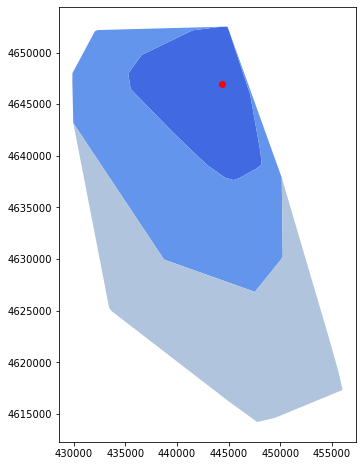

In [25]:
## NEED TO PROJECT THE POLYGONS SO THAT THECAN BE COMPARED WITH HOSPITAL AND STREET NETWORK
fig, ax = plt.subplots(figsize=(12,8))

poly[0].plot(ax=ax, color="royalblue")
poly[1].plot(ax=ax, color="cornflowerblue")
poly[2].plot(ax=ax, color="lightsteelblue")

#edges.plot(ax=ax, linewidth=0.4, color='black', alpha=0.6)
#nodes.plot(ax=ax)

hospitals[:1].plot(ax=ax, color="red")

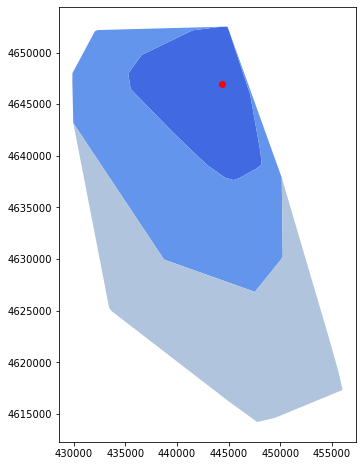

In [26]:
## NEED TO PROJECT THE POLYGONS SO THAT THECAN BE COMPARED WITH HOSPITAL AND STREET NETWORK
fig, ax = plt.subplots(figsize=(12,8))

poly2[0].plot(ax=ax, color="royalblue")
poly2[1].plot(ax=ax, color="cornflowerblue")
poly2[2].plot(ax=ax, color="lightsteelblue")

#edges.plot(ax=ax, linewidth=0.4, color='black', alpha=0.6)
#nodes.plot(ax=ax)

hospitals[:1].plot(ax=ax, color="red")

In [76]:
hospitals[:1]

,FID,Hospital,City,ZIP_Code,X,Y,Total_Bed,Adult ICU,Total Vent,geometry,nearest_osm
0,2,Methodist Hospital of Chicago,Chicago,60640,-87.671079,41.9728,145,36,12,MULTIPOINT (444399.035 4646974.016),257157489
